In [10]:
import os
import pandas
import numpy as np
import torch
import matplotlib.pyplot as plt
import hcpdatautils as hcp
import isingmodel

In [2]:
int_type = torch.int
float_type = torch.float
device = torch.device('cuda')

In [3]:
data_dir = 'E:\\Ising_model_results_daai'
model_dir = 'E:\\Ising_model_results_daai'

In [8]:
data_file_suffix = 'individual_all.pt'
data_mean_state_file = os.path.join(data_dir, f'mean_state_{data_file_suffix}')
data_mean_state = torch.load(data_mean_state_file)
print( 'data_mean_state size', data_mean_state.size() )

data_mean_state size torch.Size([837, 360])


In [9]:
data_file_suffix = 'individual_all.pt'
data_mean_state_product_file = os.path.join(data_dir, f'mean_state_product_{data_file_suffix}')
data_mean_state_product = torch.load(data_mean_state_product_file)
print( 'data_mean_state_product size', data_mean_state_product.size() )

data_mean_state_product size torch.Size([837, 64620])


In [12]:
# individual_all_fold_1_parallel_10_steps_1200_beta_sims_100.pt
# individual_all_fold_1_parallel_10_steps_12000_beta_sims_100_boltzmann_sims_250_lr_0.01.pt -not found
# individual_all_fold_1_parallel_10_steps_1200_beta_sims_100_boltzmann_sims_2500_lr_0.01.pt
# individual_all_fold_4_parallel_10_steps_12000_beta_sims_100_boltzmann_sims_1000_lr_0.01.pt
sim_file_suffix = 'individual_all_fold_1_parallel_10_steps_1200_beta_sims_100.pt'
sim_mean_state_file = os.path.join(model_dir, f'sim_mean_state_{sim_file_suffix}')
sim_mean_state = torch.load(sim_mean_state_file)
print( 'sim_mean_state size', sim_mean_state.size() )

FileNotFoundError: [Errno 2] No such file or directory: 'E:\\Ising_model_results_daai\\sim_mean_state_individual_all_fold_1_parallel_10_steps_1200_beta_sims_100_boltzmann_sims_2500_lr_0.01.pt'

In [7]:
sim_file_suffix = 'individual_all_fold_1_parallel_10_steps_1200_beta_sims_100.pt'
sim_mean_state_product_file = os.path.join(model_dir, f'sim_mean_state_product_{sim_file_suffix}')
sim_mean_state_product = torch.load(sim_mean_state_product_file)
print( 'sim_mean_state_product size', sim_mean_state_product.size() )

sim_mean_state_product size torch.Size([8370, 64620])


In [8]:
num_subjects = data_mean_state.size(dim=0)
num_replicas = sim_mean_state.size(dim=0)//num_subjects
sim_mean_state = torch.unflatten( sim_mean_state, dim=0, sizes=(num_replicas,num_subjects) )

In [9]:
num_subjects = data_mean_state_product.size(dim=0)
num_replicas = sim_mean_state_product.size(dim=0)//num_subjects
sim_mean_state_product = torch.unflatten( sim_mean_state_product, dim=0, sizes=(num_replicas,num_subjects) )

In [10]:
num_nodes = data_mean_state.size(dim=-1)
data_mean_state_product_square = torch.zeros( (num_nodes, num_nodes), dtype=float_type, device=device )
sim_mean_state_product_square = torch.zeros( (num_nodes, num_nodes), dtype=float_type, device=device )
triu_indices = torch.triu_indices(num_nodes, num_nodes, offset=1, dtype=int_type, device=device)
triu_rows = triu_indices[0]
triu_cols = triu_indices[1]
data_mean_state_product_square[triu_rows,triu_cols] = data_mean_state_product[0,:]
data_mean_state_product_square[triu_cols,triu_rows] = data_mean_state_product[0,:]
sim_mean_state_product_square[triu_rows,triu_cols] = sim_mean_state_product[0,0,:]
sim_mean_state_product_square[triu_cols,triu_rows] = sim_mean_state_product[0,0,:]

Text(0.5, 1.0, 'sim mean state products')

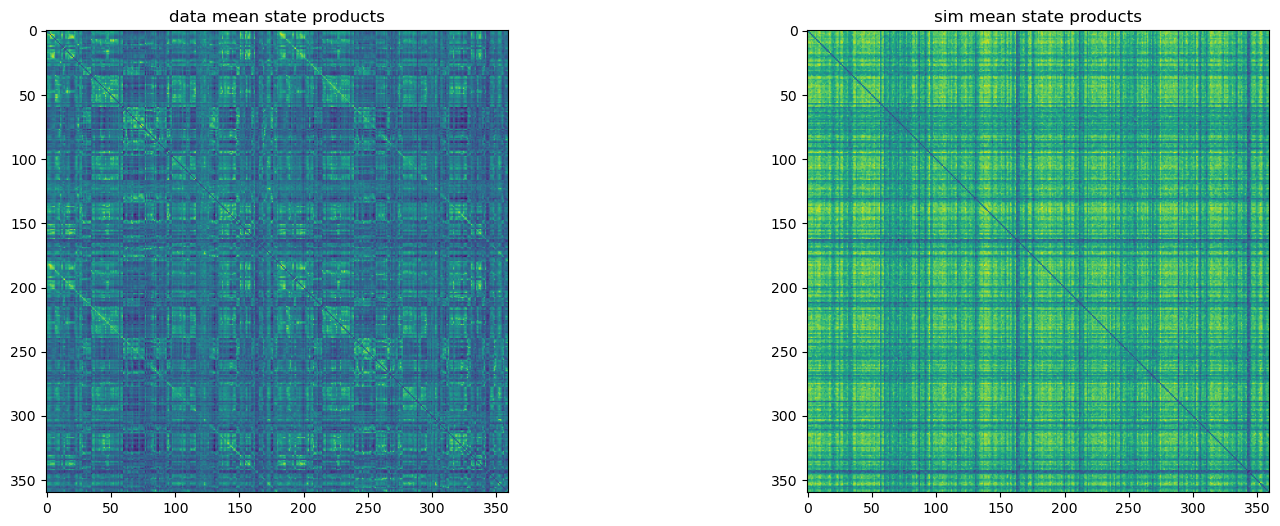

In [11]:
fig, axs = plt.subplots( nrows=1, ncols=2, figsize=(18, 6) )
axs[0].imshow( data_mean_state_product_square.detach().cpu().numpy() )
axs[0].set_title('data mean state products')
axs[1].imshow( sim_mean_state_product_square.detach().cpu().numpy() )
axs[1].set_title('sim mean state products')

In [4]:
def make_histogram(name:str, values:torch.Tensor):
    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(9, 6))
    axs.hist( values.flatten().detach().cpu().numpy() )
    # axs.set_xticklabels( axs.get_xticklabels(), rotation=90, ha='right' )
    axs.set_xlabel(name)
    axs.set_ylabel('count in bin')
    axs.set_title(f'distribution of {name}')
    plt.show()

In [5]:
def print_stats(name:str, values:torch.Tensor):
    values = values.flatten()
    quantile_cutoffs = torch.tensor([0.025, 0.5, 0.975], dtype=float_type, device=values.device)
    quantiles = torch.quantile(values, quantile_cutoffs)
    min_val = torch.min(values)
    max_val = torch.max(values)
    print(f'The distribution of {name} values has median {quantiles[1].item():.3g} with 95% CI [{quantiles[0].item():.3g}, {quantiles[2].item():.3g}] and range [{min_val.item():.3g}, {max_val.item():.3g}].')

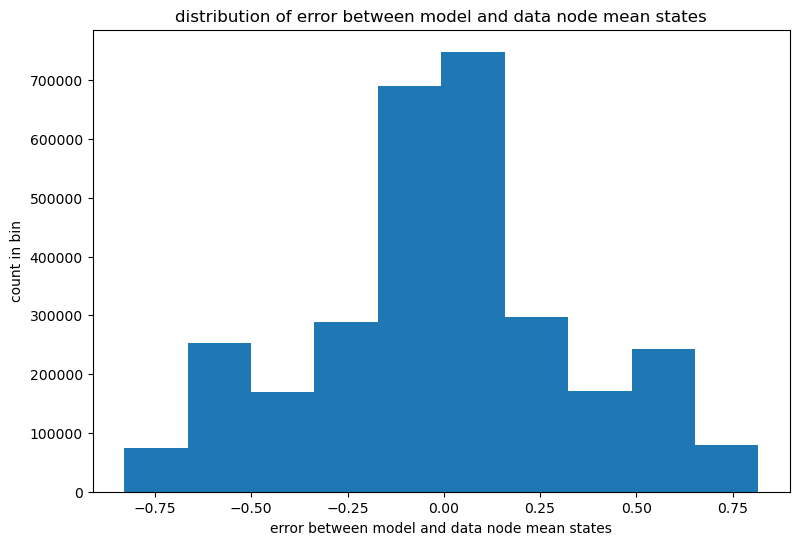

The distribution of error between model and data node mean states values has median -0.00333 with 95% CI [-0.665, 0.655] and range [-0.83, 0.817].


In [14]:
errors_of_means = sim_mean_state - data_mean_state
name = 'error between model and data node mean states'
values = errors_of_means
make_histogram(name=name, values=values)
print_stats(name=name, values=values)

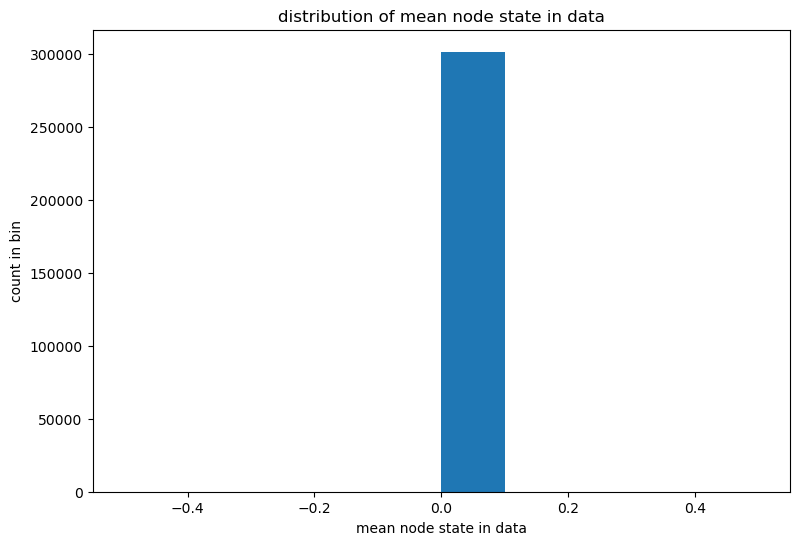

The distribution of mean node state in data values has median 0 with 95% CI [0, 0] and range [0, 0].


In [15]:
name = 'mean node state in data'
values = data_mean_state
make_histogram(name=name, values=values)
print_stats(name=name, values=values)

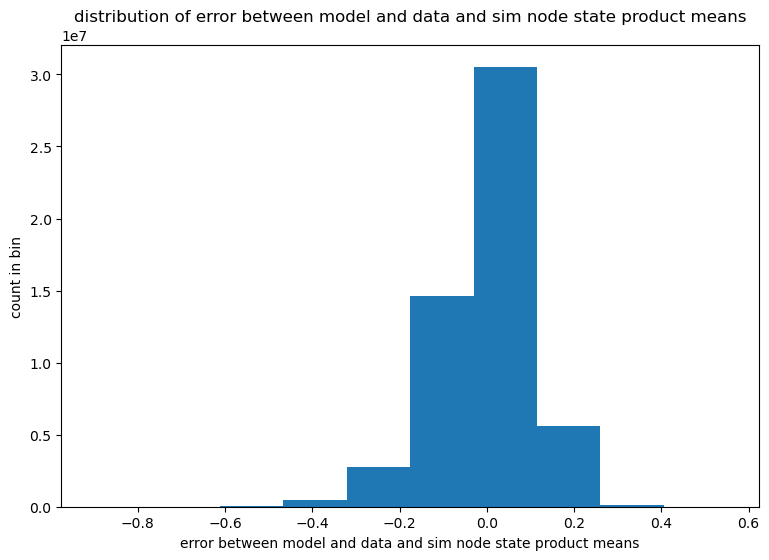

RuntimeError: quantile() input tensor is too large

In [16]:
errors_of_product_means = sim_mean_state_product - data_mean_state_product
name = 'error between model and data and sim node state product means'
values = errors_of_product_means[0,:,:]
make_histogram(name=name, values=values)
print_stats(name=name, values=values)

In [18]:
print( errors_of_product_means.min().item(), errors_of_product_means.mean().item(), errors_of_product_means.max().item() )

-0.9050000309944153 -0.0008599038701504469 0.5508333444595337


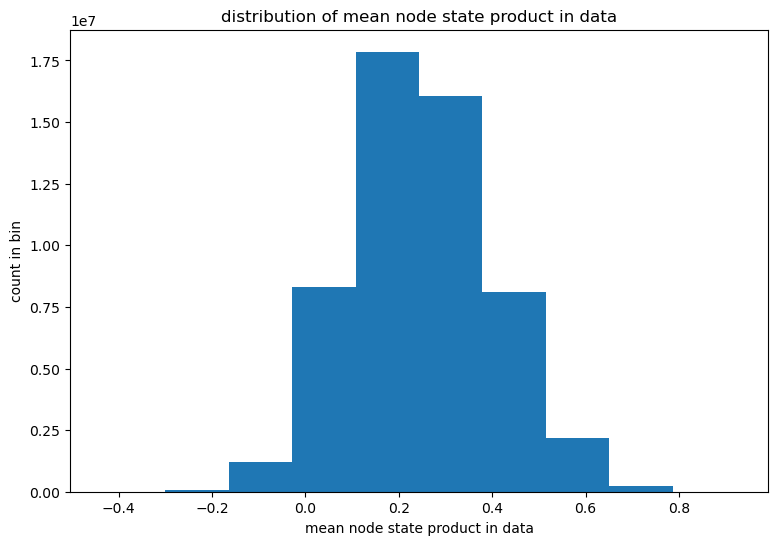

RuntimeError: quantile() input tensor is too large

In [19]:
name = 'mean node state product in data'
values = data_mean_state_product
make_histogram(name=name, values=values)
print_stats(name=name, values=values)

In [20]:
print( data_mean_state_product.min().item(), data_mean_state_product.mean().item(), data_mean_state_product.max().item() )

-0.4358333349227905 0.24765963852405548 0.9225000143051147


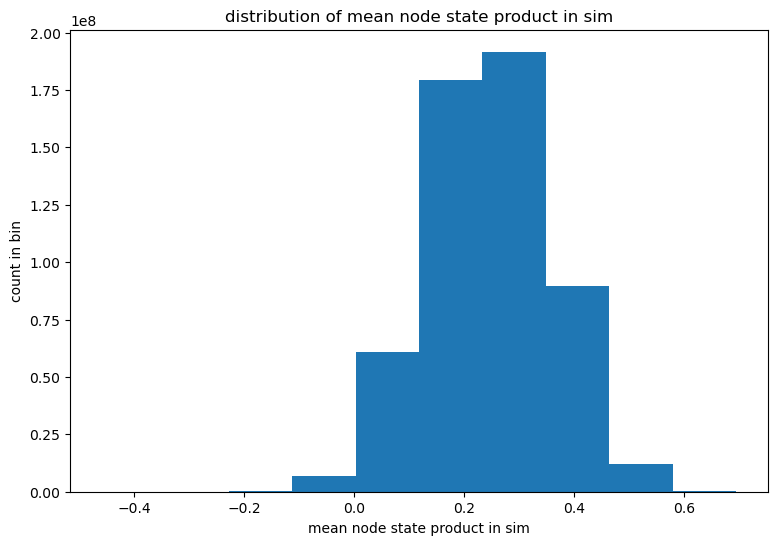

In [21]:
name = 'mean node state product in sim'
values = sim_mean_state_product
make_histogram(name=name, values=values)

In [22]:
print( sim_mean_state_product.min().item(), sim_mean_state_product.mean().item(), sim_mean_state_product.max().item() )

-0.4583333432674408 0.2467997521162033 0.6949999928474426


In [18]:
# individual_all_fold_1_parallel_10_steps_1200_beta_sims_100.pt
# individual_all_fold_1_parallel_10_steps_12000_beta_sims_100_boltzmann_sims_250_lr_0.01.pt
# individual_all_fold_1_parallel_10_steps_1200_beta_sims_100_boltzmann_sims_2500_lr_0.01.pt
# individual_all_fold_4_parallel_10_steps_12000_beta_sims_100_boltzmann_sims_1000_lr_0.01.pt
sim_file_suffix = 'individual_all_fold_1_parallel_10_steps_12000_beta_sims_100_boltzmann_sims_250_lr_0.01.pt'
fc_rmse_file = os.path.join(model_dir, f'fc_rmse_{sim_file_suffix}')
fc_rmse = torch.load(fc_rmse_file)
print( 'fc_rmse size', fc_rmse.size() )

fc_rmse size torch.Size([8370])


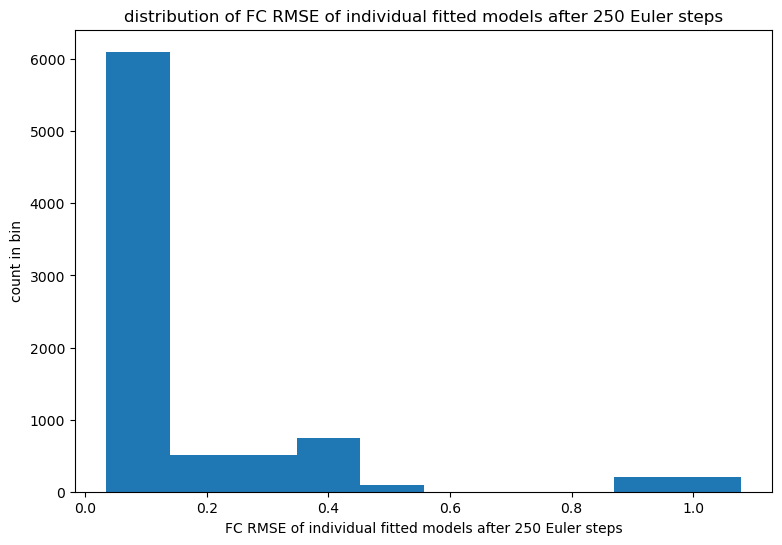

The distribution of FC RMSE of individual fitted models after 250 Euler steps values has median 0.0897 with 95% CI [0.0489, 0.974] and range [0.035, 1.08].


In [19]:
name = 'FC RMSE of individual fitted models after 250 Euler steps'
values = fc_rmse
make_histogram(name=name, values=values)
print_stats(name=name, values=values)

In [28]:
# individual_all_fold_1_parallel_10_steps_1200_beta_sims_100.pt
# individual_all_fold_1_parallel_10_steps_12000_beta_sims_100.pt
# individual_all_fold_1_parallel_10_steps_1200_beta_sims_100_boltzmann_sims_2500_lr_0.01.pt
# individual_all_fold_1_parallel_10_steps_12000_beta_sims_100_boltzmann_sims_250_lr_0.01.pt
sim_file_suffix = 'individual_all_fold_1_parallel_10_steps_12000_beta_sims_100.pt'
sim_fc_file = os.path.join(model_dir, f'sim_fc_{sim_file_suffix}')
sim_fc = torch.load(sim_fc_file)
print( 'sim_fc size', sim_fc.size() )

sim_fc size torch.Size([8370, 64620])


In [29]:
sim_fc = sim_fc.unflatten( dim=0, sizes=(10, 837) )

In [30]:
data_fc_file = os.path.join(model_dir, 'fc_individual_all.pt')
data_fc = torch.load(data_fc_file)
print( 'data_fc size', data_fc.size() )

data_fc size torch.Size([837, 64620])


In [31]:
data_fc = data_fc.unsqueeze(dim=0).repeat( (10,1,1) )

In [32]:
fc_correlation = isingmodel.get_pairwise_correlation(sim_fc, data_fc)
print( fc_correlation.size() )

torch.Size([10, 837])


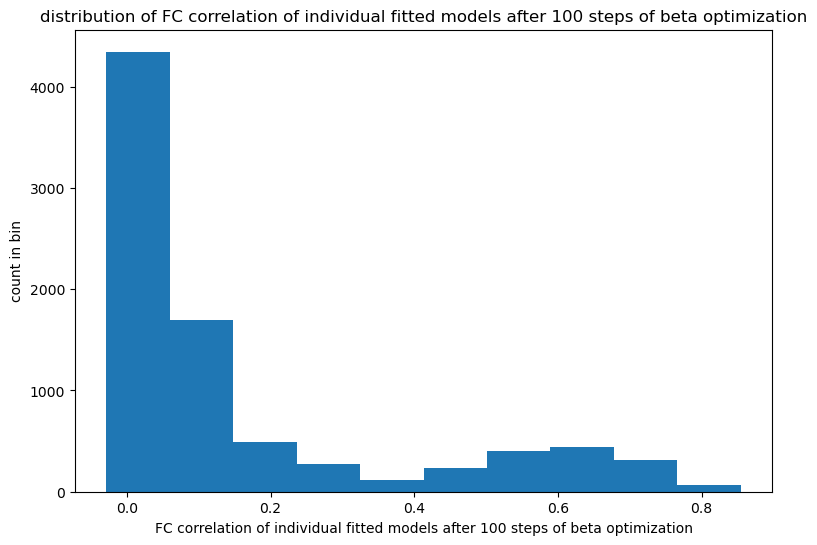

The distribution of FC correlation of individual fitted models after 100 steps of beta optimization values has median 0.0554 with 95% CI [0.000138, 0.718] and range [-0.0285, 0.854].


In [33]:
name = 'FC correlation of individual fitted models after 100 steps of beta optimization'
values = fc_correlation
make_histogram(name=name, values=values)
print_stats(name=name, values=values)

In [61]:
# params_file = os.path.join(model_dir, 'params_simple_euler_from_expected_group_training_threshold_median_parallel_10000_updates_10000_sim_length_1200_learning_rate_0.001_beta_0.0122000000000000007743805596760466869.pt')
params_file = os.path.join(model_dir, 'params_simple_euler_from_expected_group_training_threshold_median_parallel_10000_updates_1000_sim_length_12000_learning_rate_0.01_beta_0.0122000000000000007743805596760466869.pt')
# params_file = os.path.join(model_dir, 'params_simple_euler_from_expected_group_training_threshold_median_parallel_10000_updates_1000_sim_length_1200_learning_rate_0.1_beta_0.0122000000000000007743805596760466869.pt')
params = torch.load(params_file)
print( params.size() )

torch.Size([64980])


In [62]:
num_nodes = 360
h = params[:num_nodes]
J_triu = params[num_nodes:]
J = torch.zeros( (num_nodes, num_nodes), dtype=float_type, device=device )
triu_indices = torch.triu_indices(num_nodes, num_nodes, offset=1, dtype=int_type, device=device)
triu_rows = triu_indices[0]
triu_cols = triu_indices[1]
J[triu_rows,triu_cols] = J_triu
J[triu_cols,triu_rows] = J_triu

Text(0.5, 1.0, 'data mean observables')

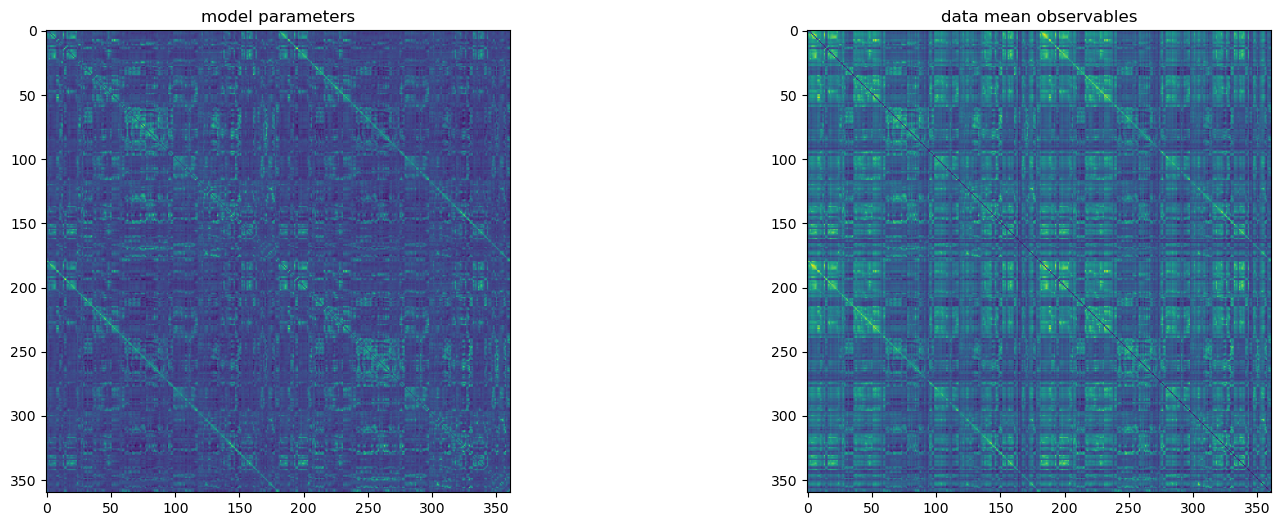

In [63]:
fig, axs = plt.subplots( nrows=1, ncols=2, figsize=(18, 6) )
params_block = torch.cat( (h[:,None], J), dim=1 )
axs[0].imshow( params_block.detach().cpu().numpy() )
axs[0].set_title('model parameters')
data_observables_block = torch.cat( (data_means[:,None], data_product_means_mat), dim=1 )
axs[1].imshow( data_observables_block.detach().cpu().numpy() )
axs[1].set_title('data mean observables')

In [66]:
print(num_nodes)
num_params = num_nodes + num_nodes * (num_nodes - 1)//2
print(num_params)

360
64980
56


In [98]:
subject_ids = hcp.load_subject_subset(directory_path='E:\\HCP_data', subject_subset='all', require_sc=True)
print( 'num subjects:', len(subject_ids) )
for subject_id in subject_ids:
    if (subject_id <= 99999) or (subject_id > 999999):
        print(subject_id, 'does not have 6 digits')

num subjects: 837


In [23]:
fc_rmse_file = os.path.join(data_dir, 'fc_rmse_individual_all_fold_4_parallel_10_steps_12000_beta_sims_100_boltzmann_sims_1000_lr_0.01.pt')
fc_rmse = torch.load(fc_rmse_file)
print( fc_rmse.size() )

torch.Size([33480])


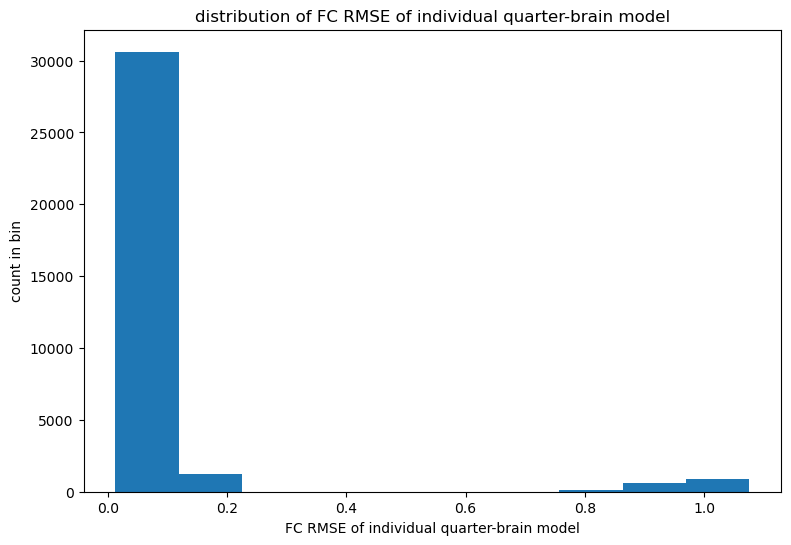

The distribution of FC RMSE of individual quarter-brain model values has median 0.0367 with 95% CI [0.0183, 0.973] and range [0.0129, 1.08].


In [25]:
name = 'FC RMSE of individual quarter-brain model'
values = fc_rmse
make_histogram(name=name, values=values)
print_stats(name=name, values=values)

In [4]:
model_file = os.path.join(data_dir, 'ising_model_individual_all_fold_1_parallel_10_steps_12000_beta_sims_100_boltzmann_sims_250_lr_0.01.pt')
model = torch.load(model_file)
print( model.s.size() )

torch.Size([8370, 360])
